## 1. 시계열 데이터 준비

### 데이터 불러와서 'Date'를 기준으로 'Close' 추출

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#path = os.getenv('HOME')+'/project/aiffel-lms/F6_Stock_Prediction/data/naver.csv'
path = os.getenv('HOME')+'/project/aiffel-lms/E6_Stock/data/samsung.csv'
df = pd.read_csv(path, index_col='Date', parse_dates=True)
ts = df['Close']
print(type(ts))
ts.head()


<class 'pandas.core.series.Series'>


Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

### 데이터를 차트로 표현

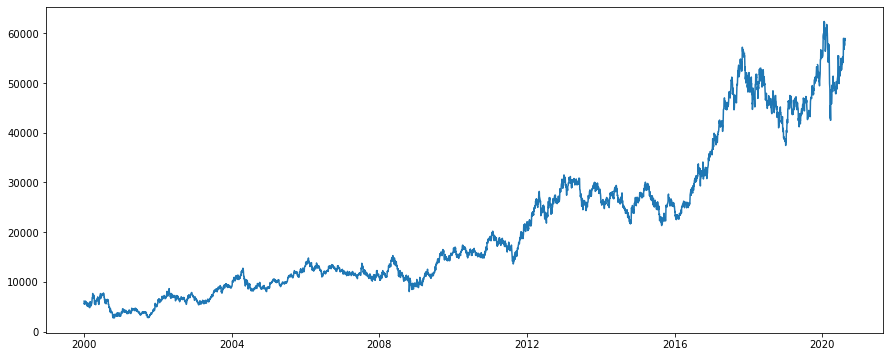

In [2]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
plt.plot(ts)

### 결측치 확인하고 보간처리

In [3]:
ts[ts.isna()]

Date
2000-12-25   NaN
2001-01-23   NaN
2001-01-24   NaN
2001-01-25   NaN
2001-03-14   NaN
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64

In [4]:
ts=ts.interpolate(method='time')
ts[ts.isna()]




Series([], Name: Close, dtype: float64)

---
## 2. 시계열 안정성 분석 

### 평균과 표준편차 시각화

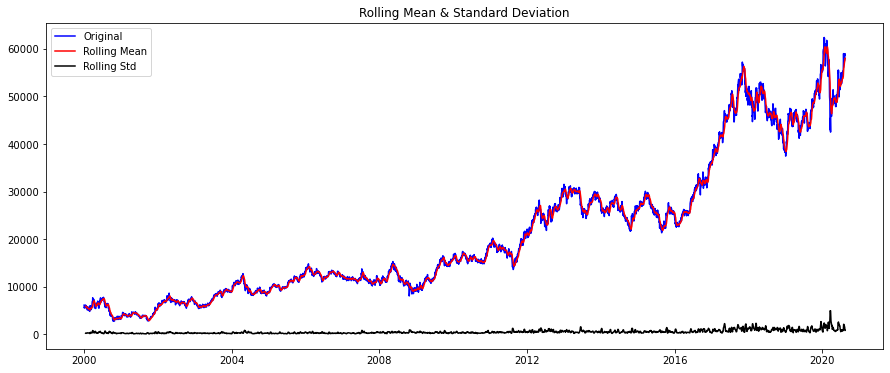

In [5]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    origin = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

plot_rolling_statistics(ts, window=12)

### 정량적 Augmented Dicky-Fuller Test

[Results of Dickey-Fuller Test]
Test Statistic                   -0.687281
p-value                           0.850017
#Lags Used                        4.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


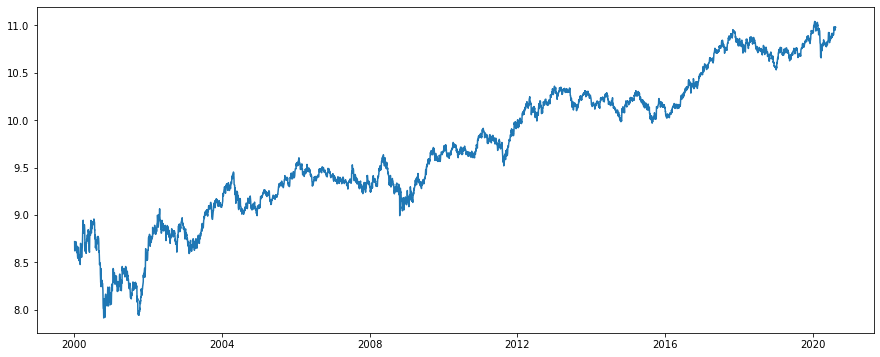

In [6]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    print('[Results of Dickey-Fuller Test]')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

ts_log = np.log(ts)
plt.plot(ts_log)

augmented_dickey_fuller_test(ts_log)

### 시계열 분해

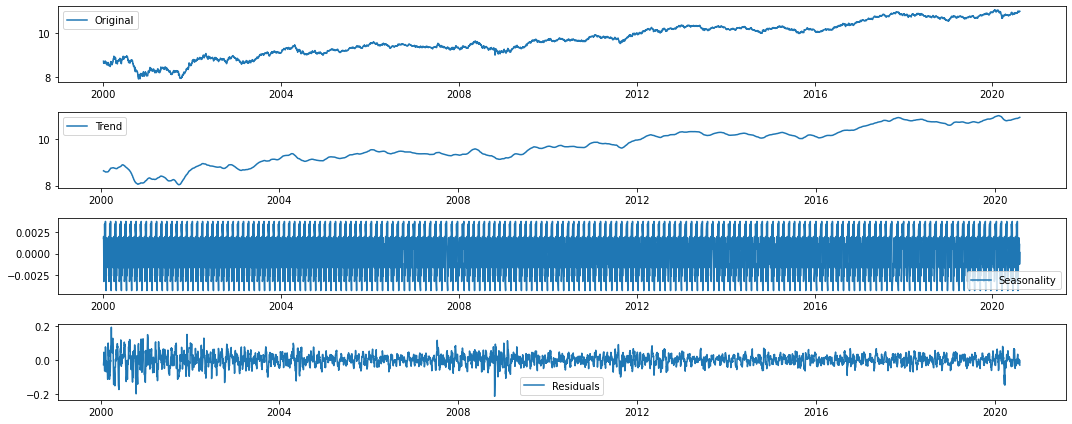

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log, model='additive', period = 30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Residual 확인

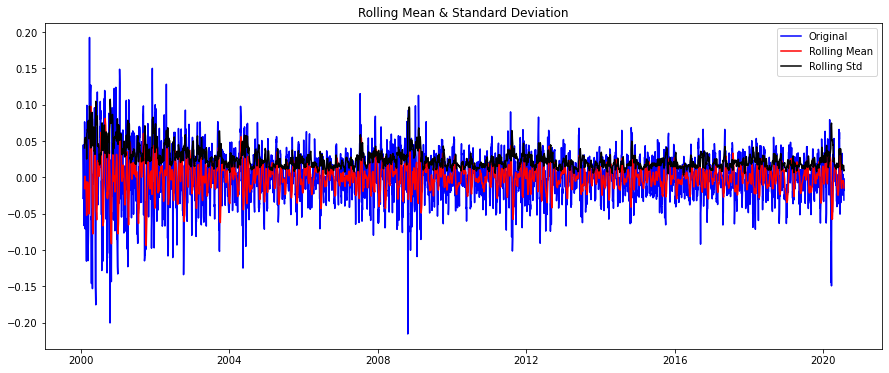

In [8]:
plot_rolling_statistics(residual)

In [9]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

[Results of Dickey-Fuller Test]
Test Statistic                -1.725075e+01
p-value                        6.025663e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.123000e+03
Critical Value (1%)           -3.431627e+00
Critical Value (5%)           -2.862104e+00
Critical Value (10%)          -2.567070e+00
dtype: float64


---
## 3. 학습, 테스트 데이터셋 생성

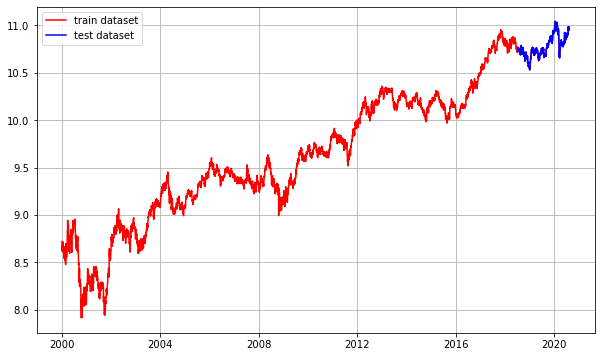

In [10]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(ts_log, c='r', label='train dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

---
## 4. 적정 ARIMA 모수 찾기

### ACF, PACF 그려서 p, q 찾기

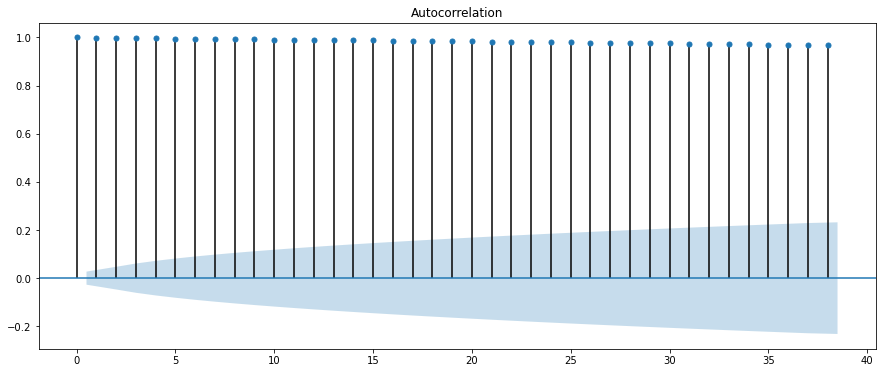

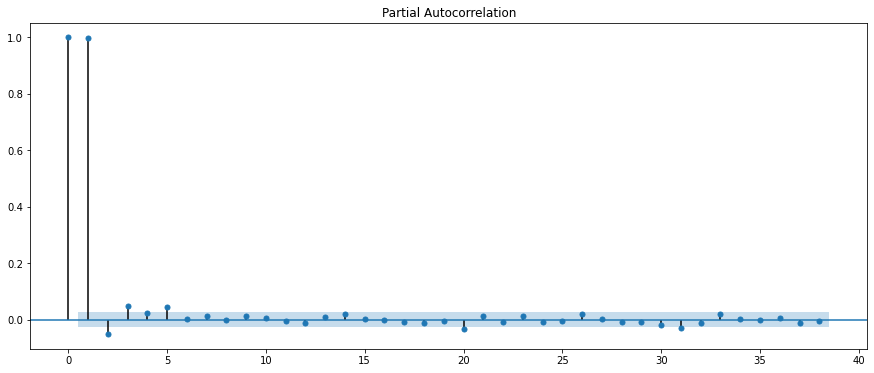

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)

plt.show()

### 차분 안정성 확인해서 d 구하기

[Results of Dickey-Fuller Test]
Test Statistic                  -39.817874
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64
[Results of Dickey-Fuller Test]
Test Statistic                  -21.584636
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5151.000000
Critical Value (1%)              -3.431620
Critical Value (5%)              -2.862101
Critical Value (10%)             -2.567069
dtype: float64


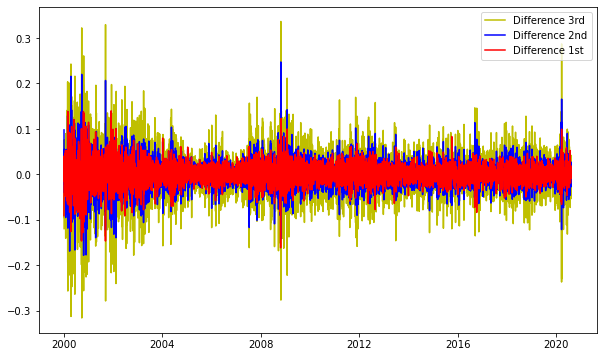

In [12]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
augmented_dickey_fuller_test(diff_1)

diff_2 = diff_1.diff(periods=1).iloc[1:]

diff_3 = diff_2.diff(periods=1).iloc[1:]

augmented_dickey_fuller_test(diff_2)

plt.figure(figsize=(10, 6))

plt.plot(diff_3, c='y', label='Difference 3rd')
plt.plot(diff_2, c='b', label='Difference 2nd')
plt.plot(diff_1, c='r', label='Difference 1st')
plt.legend()

---
## 6. ARIMA 모델 훈련과 테스트

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4667
Model:                 ARIMA(1, 1, 2)   Log Likelihood               11005.952
Method:                       css-mle   S.D. of innovations              0.023
Date:                Fri, 14 Aug 2020   AIC                         -22001.905
Time:                        17:27:42   BIC                         -21969.663
Sample:                             1   HQIC                        -21990.565
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.530      0.126      -0.000       0.001
ar.L1.D.Close     0.6134      0.080      7.649      0.000       0.456       0.771
ma.L1.D.Close    -0.5685      0.080     

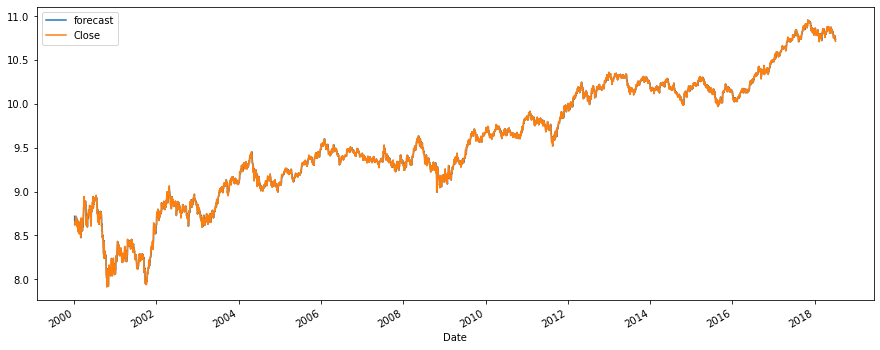

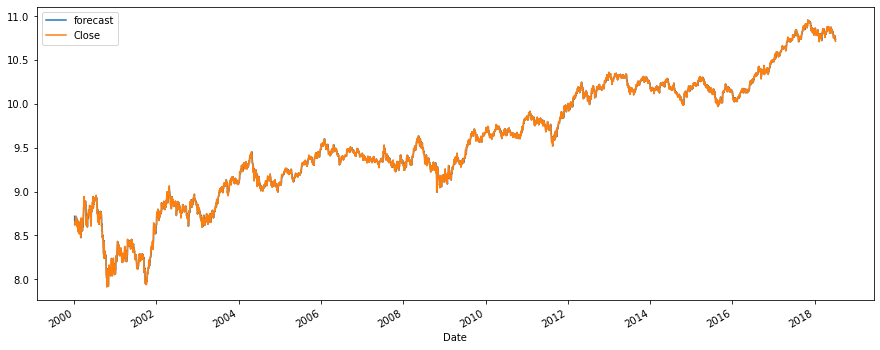

In [13]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(1,1,2))
fit_model = model.fit(disp=-1)
print(fit_model.summary())

fit_model.plot_predict()

### 모델 테스트 및 플로팅

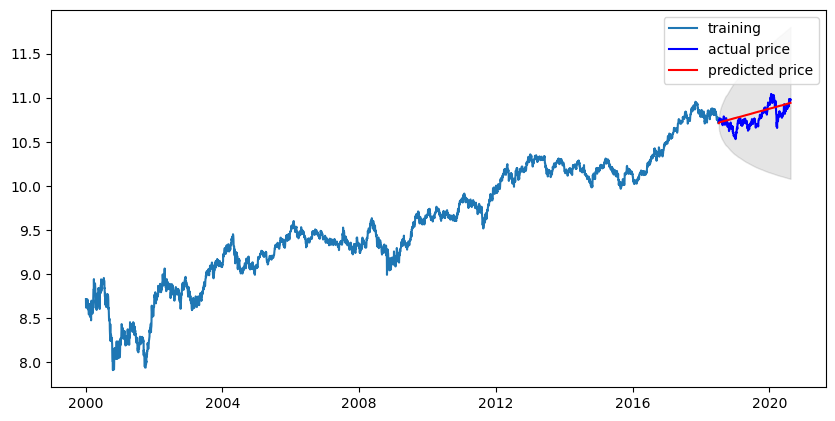

In [14]:
fc, se, conf = fit_model.forecast(len(test_data), alpha=0.05)

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:,0], index=test_data.index)
upper_series = pd.Series(conf[:,1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()


### 최종 예측 모델 정확도 측정(MAPE)

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  20379205.26338743
MAE:  3801.2091679437253
RMSE:  4514.333313279762
MAPE: 8.17%


---
## 다른 종목 예측

### Google

[Results of Dickey-Fuller Test]
Test Statistic                   -2.863607
p-value                           0.049747
#Lags Used                       27.000000
Number of Observations Used    9231.000000
Critical Value (1%)              -3.431059
Critical Value (5%)              -2.861853
Critical Value (10%)             -2.566937
dtype: float64


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


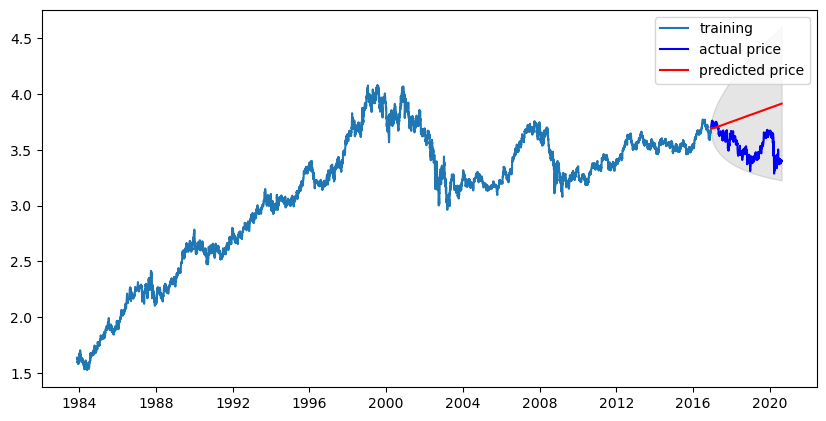

MSE:  134.00541303569102
MAE:  10.122840214884569
RMSE:  11.576070707960064
MAPE: 30.97%


In [19]:
path = os.getenv('HOME')+'/project/aiffel-lms/E6_Stock/data/GOOG.csv'
df = pd.read_csv(path, index_col='Date', parse_dates=True)
ts = df['Close']

ts=ts.interpolate(method='time')
ts[ts.isna()]

ts_log = np.log(ts)

augmented_dickey_fuller_test(ts_log)

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

model = ARIMA(train_data, order=(1,1,2))
fit_model = model.fit(disp=-1)

fc, se, conf = fit_model.forecast(len(test_data), alpha=0.05)

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:,0], index=test_data.index)
upper_series = pd.Series(conf[:,1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


### Facebook

[Results of Dickey-Fuller Test]
Test Statistic                   -1.179479
p-value                           0.682360
#Lags Used                       10.000000
Number of Observations Used    2062.000000
Critical Value (1%)              -3.433525
Critical Value (5%)              -2.862943
Critical Value (10%)             -2.567517
dtype: float64


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


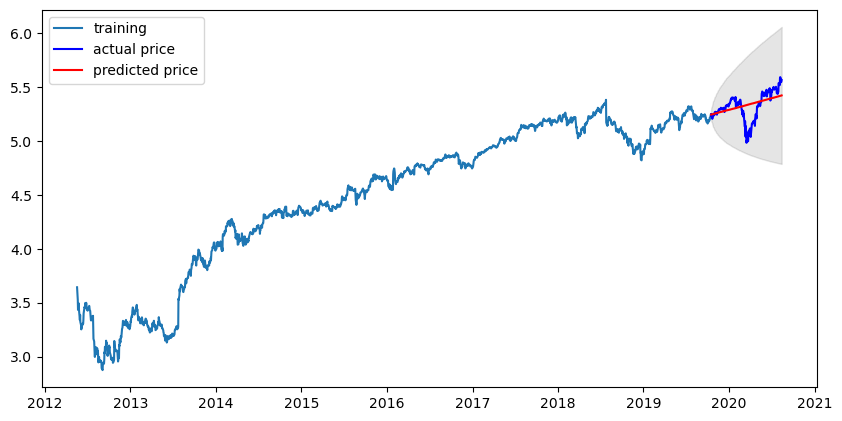

MSE:  492.7104901956696
MAE:  16.73376858422515
RMSE:  22.19708292086304
MAPE: 8.66%


In [17]:
path = os.getenv('HOME')+'/project/aiffel-lms/E6_Stock/data/FB.csv'
df = pd.read_csv(path, index_col='Date', parse_dates=True)
ts = df['Close']

ts=ts.interpolate(method='time')
ts[ts.isna()]

ts_log = np.log(ts)

augmented_dickey_fuller_test(ts_log)

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

model = ARIMA(train_data, order=(1,1,2))
fit_model = model.fit(disp=-1)

fc, se, conf = fit_model.forecast(len(test_data), alpha=0.05)

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:,0], index=test_data.index)
upper_series = pd.Series(conf[:,1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


### SKT

[Results of Dickey-Fuller Test]
Test Statistic                   -2.752385
p-value                           0.065404
#Lags Used                        0.000000
Number of Observations Used    1227.000000
Critical Value (1%)              -3.435691
Critical Value (5%)              -2.863898
Critical Value (10%)             -2.568026
dtype: float64


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


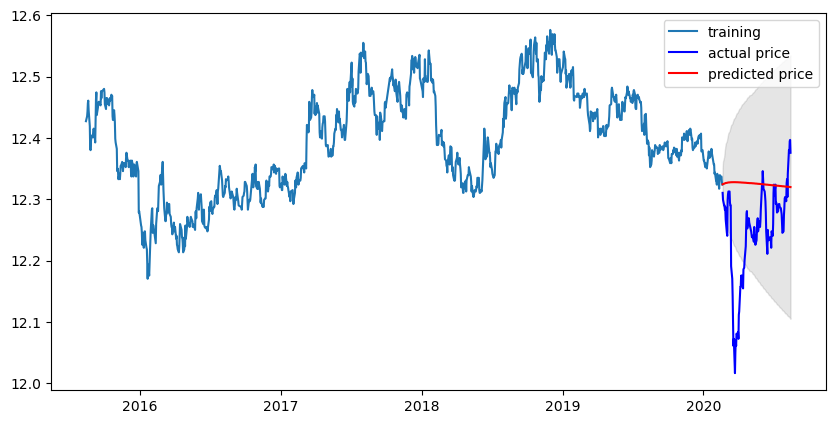

MSE:  503583277.294773
MAE:  17376.500105646253
RMSE:  22440.661249053537
MAPE: 8.87%


In [18]:
path = os.getenv('HOME')+'/project/aiffel-lms/E6_Stock/data/skt_.csv'
df = pd.read_csv(path, index_col='Date', parse_dates=True)
ts = df['Close']

ts=ts.interpolate(method='time')
ts[ts.isna()]

ts_log = np.log(ts)

augmented_dickey_fuller_test(ts_log)

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

model = ARIMA(train_data, order=(1,1,2))
fit_model = model.fit(disp=-1)

fc, se, conf = fit_model.forecast(len(test_data), alpha=0.05)

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:,0], index=test_data.index)
upper_series = pd.Series(conf[:,1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


---
## Report

1. 적절한 p,d,q를 구하는 과정을 이해하기 힘들고 값을 변경해도 MAPE값에 큰 변화가 없었음
2. q값을 키울수록 연산량이 늘어나는 것을 확인
3. 주식마다 변화 정도에 따라 예측 성능이 크게 달랐음
4. 기간을 극도로 줄이면 예측 성능이 늘어나는 것으로 확인
5. 코로나로 주식 변동성이 커져서 예측이 더 힘든 것으로 예상하고 기간을 설정해보았지만 나아지지 않았음